# EXPERIMENTO - ENFOQUES AVANZADOS: LSTM - CNN - HÍBRIDO

Se realiza la experimentación sobre enfoques neuronales, haciendo uso de capas LSTM, CNN y un modelo HÍBRIDO (combinación de LSTM y CNN).

Primero se descargan los *Embeddings de Fast-Text* (para realizar esta acción por única vez), se carga el dataset a estudiar (ubicación especificada en "Configuraciones para la Ejecución") y se procede a realizar todas las acciones para la generación de la *Capa de Embeddings*. Luego se realizan todas las experimentaciones para cada tipo de Red Neuronal.

## Librerías necesarias

In [ ]:
#Librerias utiles
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re
import unicodedata
from sklearn.model_selection import train_test_split

#PREPROCESAMIENTO USANDO STOPWORDS DE NLTK => 313 PALABRAS
#from nltk.tokenize import word_tokenize
import nltk 
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
import tensorflow as tf

#Representación de Textos
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer #No lo uso (hice un tokenizador personalizado)
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

#Embeddings
from keras.layers import Embedding
from keras.initializers import Constant

#Embeddings Pre-Entrenados
from gensim.models import KeyedVectors

#Construcción Modelo NN LSTM
from keras.layers import Dense, Input
from keras.layers import LSTM, Bidirectional, Dropout, SpatialDropout1D,GlobalAveragePooling1D
from keras.models import Model, Sequential
from keras.optimizers import Adam, SGD

#Construcción Modelo NN Convolucional
from keras.layers import Dense, Input, GlobalMaxPooling1D, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM, Concatenate, Input
from keras.models import Model, Sequential

#Construcción Modelo NN Híbrido: LSTM + CNN
from keras.layers import Concatenate, Input

#Evaluación de Resultados
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

#Graficar resultados
from keras.utils import plot_model
from IPython.display import Image, display


REPRODUCIBILIDAD EN TensorFlow

In [ ]:
#REPRODUCIBILIDAD DE RESULTADOS
#La reproducibilidad de resultados 
import os
from os import path
import random
#Setear valor Seed para hacer los resultados reproducibles
#    Esto es importante: Trabajamos con un dataset muy chico => Los valores de Accuracy pueden ser cambiar significativamente
#En Modelos de Aprendizaje Profundo es difícil lograr la Reproducibilidad de Resultados
#   Siempre hay una aleatoriedad inherente presente en la actualización de los pesos de las distintas capas
#   Además, algunos requieren que sean ejecutados en un mismo entorno (paquetes, características de la maquina, etc)  
seed_val = 2020
def reset_random_seed():
  random.seed(seed_val)
  np.random.seed(seed_val) #Semilla para bibliotecas usadas (Ej: algunas biblitecas usan numpy random generator)
  tf.random.set_seed(seed_val) # Semilla para tensorflow
  os.environ['PYTHONHASHSEED']=str(seed_val)  #Establecer variable de entorno fijo

reset_random_seed()

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print("Device:", tpu.master())
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
#print("Number of replicas:", strategy.num_replicas_in_sync)


#from keras import backend as K
#session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
#K.set_session(sess)

#from keras import backend as K
#config = tf.tfConfigProto(intra_op_parallelism_threads=1,inter_op_parallelism_threads=1)
#tf.set_random_seed(sd)
#sess = tf.Session(graph=tf.get_default_graph(), config=config)
#K.set_session(sess)

## Configuraciones para la Ejecución

Setear siguientes las configuraciones:

###1.   Dataset a utilizar: Ubicación y/o nombre de cada archivo
Para usar dataset 1 (DS1) colocar flag en True, en otro caso, se aplica el estudio sobre el dataset 2 (DS2)

###2.   Setear el tamaño de Conjunto de Validación
El flag VALID_SIZE será utilizado para reservar una porción del conjunto train y es de utilidad para llevar el registro de progreso de cada modelo durante el proceso de entrenamiento.

###3.   Almacenamiento de Resultados y Reportes
Setear nombres de archivos para el almacenamiento de los resultados finales



In [ ]:
#CONFIGURACIONES PARA LA EJECUCIÓN


#--------------------------------------------------------------
#1. Dataset a utilizar: Ubicación y/o nombre de cada archivo
#--------------------------------------------------------------

#DS1 = Consultas Usuario + Extensiones + Consultas AFIP (Integración Total)
#   >> Setear DS_select = True
#DS2 = Consultas Usuario + Extensiones | Test: Consultas AFIP
#   >> Setear DS_select = False
DS1_select = True
if DS1_select: 
  #Será dividido en 80/20 para training/test
  DS_NAME = "DS1_usuario_afip.csv"
  TEST_NAME = None
else:
  DS_NAME = "DS2-train_usuario.csv"
  TEST_NAME = "DS2-test_afip.csv"

#--------------------------------------------------------------
#2. Setear el tamaño de Conjunto de Validación 
#--------------------------------------------------------------
#2. Setear tamaño de Conj. Validation
VALID_SIZE = 0.1


#--------------------------------------------------------------
#3. Almacenamiento de Resultados y Reportes
#--------------------------------------------------------------
#Archivo de Resultados
DF_RESULTADOS = pd.DataFrame(columns=["Dataset", "Modelo", "lossTrain", "accValid", "accTestFinal"])
FILE_NAME_RES = "Resultados_CNN-LSTM-HIBRIDO.csv"

#REGISTRO DE PREGUNTAS MAL CLASIFICADAS
DF_MAL_CLF =  pd.DataFrame(columns=["DS", "MOD", "Texto", "Predicho","Real"])
FILE_NAME_CLF = "PregMalClasif_CNN-LSTM-HIBRIDO.csv"

##**Descargar Embeddings Pre-entrenados**

Descargar *Embeddings de Fast-Text* (u otra librería de interés) para la Representación de Documentos y creación de la *Capa de Embedding*

In [ ]:
#--------------------------------------------------------------
# Descargar Embeddings Pre-entrenados
#--------------------------------------------------------------

#Setear tipo de embedding a trabajar: 
# - ft_chile: fasttext - Universidad de Chile -> wiki.es.vec FastText Español entrenado con Wikipedia
# - ft_mult : fasttext multilenguaje
# - sinEMB : Sin embeddings pre-entrenados

EMB_MOD = 'ft_chile'

if not path.exists("wiki.es.vec"):
  # Descargar el archivo con los vectores
  print("Descargando Embeddings pre-entrenados")
  !wget -q https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.es.vec
      ##!wget -q http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.100k.vec.gz
      ##!wget -q http://dcc.uchile.cl/~jperez/word-embeddings/fasttext-sbwc.vec.gz
  print(">> OK!\n")
  # Descomprimir Archivo
  !gzip -d -q wiki.es.vec
      ##!gzip -d -q fasttext-sbwc.100k.vec.gz
      ##!gzip -d -q fasttext-sbwc.vec
      
# Verificar que los archivos sean descargados correctamente: Debe estar `fasttext-sbwc.100k.vec`
print("Directorio:")
!ls
print("\nCargar Embeddings pre-entrenados - wiki.es.vec")
#Librería necesaria: from gensim.models import KeyedVectors
we = KeyedVectors.load_word2vec_format('wiki.es.vec', limit=1000000)
    ##we = KeyedVectors.load_word2vec_format('fasttext-sbwc.100k.vec', limit=100000)
    ##we = KeyedVectors.load_word2vec_format('fasttext-sbwc.vec', limit=100000)
print(">> OK!")
print("Dimension de Vectores de Embeddings:", we.vectors.shape)
print("Algunas palabras:", np.array(list(we.vocab))[200:250])

Descargando Embeddings pre-entrenados
>> OK!

Directorio:
DS1_usuario_afip.csv  sample_data  wiki.es.vec

Cargar Embeddings pre-entrenados - wiki.es.vec
>> OK!
Dimension de Vectores de Embeddings: (985667, 300)
Algunas palabras: ['estaba' 'l' 'estos' 'abril' 'total' 'región' 'sistema' 'habitantes' 'me'
 'maría' 'real' 'página' 'esto' 'mundial' 'música' 'presidente' '!' 'casa'
 'sólo' 'álbum' 'debido' 'cuenta' 'junio' 'febrero' 'ella' 'pueden'
 'varios' 'francia' 'solo' 'chile' 'tipo' 'obra' 'iglesia' 'película'
 'entonces' 'banda' 'cuatro' 'zona' 'televisión' 'q' 'principal' 'tuvo'
 'carlos' 'otra' 'ee' 'rey' 'premio' 'hace' 'km²' 'edición']


In [ ]:
#Inspeccionar algunos embeddings 
print("Inspección de fast-text (Universidad de Chile)\n")

print("Vector Embedding: 'que' (primeras 10 de", len(we['que']), "componentes)")
print("[", *(we['que'][:10]), sep="  ", end="  ...]\n\n")

print("Vector Embedding: 'monotributo' (primeras 10 de", len(we['monotributo']), "componentes)")
print("[", *(we['monotributo'][:10]), sep="  ", end="  ...]\n\n")

print("Vector Embedding: '¿' (primeras 10 de", len(we['¿']), "componentes)")
print("[", *(we['¿'][:10]), sep="  ", end="  ...]\n\n")

print("Vector Embedding: 'importes' (primeras 10 de", len(we['importes']), "componentes)")
print("[", *(we['importes'][:10]), sep="  ", end="  ...]\n\n")

Inspección de fast-text (Universidad de Chile)

Vector Embedding: 'que' (primeras 10 de 300 componentes)
[  -0.038702  0.0086242  0.00077157  0.011074  0.14201  0.12204  -0.0049101  0.17932  -0.02433  -0.30732  ...]

Vector Embedding: 'monotributo' (primeras 10 de 300 componentes)
[  -0.15244  -0.042255  0.02074  0.0271  -0.17919  0.11453  -0.23615  0.15526  0.26765  0.01811  ...]

Vector Embedding: '¿' (primeras 10 de 300 componentes)
[  -0.45107  0.062691  -0.1235  0.022199  0.55728  0.1386  -0.16923  -0.067907  -0.14302  0.20052  ...]

Vector Embedding: 'importes' (primeras 10 de 300 componentes)
[  -0.018326  0.14276  -0.28565  -0.12643  0.1549  0.54553  -0.34863  0.31346  -0.051642  -0.27483  ...]



## Carga de Datos y Preprocesamiento

La función load_dataset(..) genera el dataset a evaluar guardando los datos en df_train y df_test. Luego realiza el preprocesamiento de los datos considerando, en particular, el uso de stopwords (con filtro de palabras importantes), corrección de palabras, entre otros. 

In [ ]:
#--------------------------------------------------------------
# Funciones de Carga de Datos y Preprocesamiento 
#--------------------------------------------------------------
correccion_palabras = { 'aherir' : 'adherir', 'aniticipo' : 'anticipo', 'baje' : 'baja','caracterísiticas' : 'caracteristicas','caragas' : 'cargas',
                        'caratacterísticas' : 'caracteristicas','condiminios' : 'condominios','constribuyentes' : 'contribuyentes','deden' : 'deben',
                        'incripto' : 'inscripto','infromé' : 'informe','inregular' : 'irregular','inscriibirme' : 'inscribirme','monostributista' : 'monotributista',
                        'monotribustistas' : 'monotributistas','monotributisa' : 'monotributista','monotributistas' : 'monotributistas',
                        'opraciones' : 'operaciones','parámentros' : 'parametros','permanezo' : 'permanezco','porciento' : 'por ciento',
                        'porqué' : 'por que','previsioanl' : 'previsional','qié' : 'que','registo' : 'registro','reitegren' : 'reintegren',
                        'requisistos' : 'requisitos','resposable' : 'responsable','semetre' : 'semestre','siginifica' : 'significa',
                        'situadios' : 'situados','solitar' : 'solicitar','trancurrir' : 'transcurrir' }

palabras_importantes = ['como', 'cual', 'cuando', 'desde', 'donde', 'durante', 'entre', 'es', 'esta', 'estar',
                        'hasta', 'hay', 'mas', 'no', 'para', 'por', 'porque', 'que', 'quienes', 'si', 'son']

def obtener_stopwords():
    stop_words = set(stopwords.words('spanish')) 
    #Eliminar acentos de stopwords
    stopwords_final = []
    for st in list(stop_words):
        stopwords_final.append(''.join(c for c in unicodedata.normalize('NFD', st) if unicodedata.category(c) != 'Mn')) 
    stopwords_sp = set(stopwords_final) - set(palabras_importantes) 
    #stopwords_sp = set(stopwords_final)
    return stopwords_sp

def usar_stopword(texto):
  #uso de stopwords
  stopwords_sp = obtener_stopwords()
  tokens = texto.split(' ')
  tkns_limpios = [] 
  for tk in tokens: 
    if tk not in stopwords_sp: #SOLO QUEDAN: SIGNOS - FECHAS - DIGITOS - PALABRAS(longitud>1)
      if tk.count('(')>0 or tk.count(')')>0 or tk.count('¿')>0 or tk.count('?')>0 or tk.count('/')>0 or tk.count('%')>0 or tk.count('.')>0 or tk.count(',')>0 or tk.isdigit() or (tk.isalpha() and (len(tk)>1)): 
        tkns_limpios.append(tk) 
  if tkns_limpios!=[]:
      return ' '.join(tkns_limpios)
  else:
      return "cadena_vacia"

def preprocesamiento(texto):
    texto = re.sub(r'[^\w ¿?%/().,]', "", texto)   #Eliminar TODO menos: \w = alphanum y ¿?%/ ANDA BIEN
    #texto = re.sub(r'[^\w ]', "", texto)   #Eliminar TODO menos: \w = alphanum y ¿?%/ 
    texto = texto.lower()   #Texto a minúscula 
    #Reescritura de palabras mal escritas
    texto = ''.join(correccion_palabras[w] if w in correccion_palabras else w for w in re.split(r'(\W+)', texto)) 
    #Eliminar acentos -> VERR
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn') 
    #Remover letras con 2 ocurrencias (con excepciones)      
    letras_dobles = "abdfghijkmnñpqstuvwxyz" # Excepciones: ee-cc-ll-rr-oo (y mayus)
    letras_dobles += letras_dobles.upper()          
    texto = re.sub("(?P<char>[" + re.escape(letras_dobles) + "])(?P=char)+", r"\1", texto) 
    #remover caracteres que se repiten al menos 3 veces
    texto = re.sub(r'([\w\W])\1{2,}', r'\1', texto) 
    #remover palabras que se repiten 
    texto = re.sub(r'\b(\w+)(\b\W+\b\1\b)*', r'\1', texto) 
    texto = re.sub(r",", " , ", texto)
    texto = re.sub(r"\.", " . ", texto)
    texto = re.sub(r"\(", " ( ", texto)
    texto = re.sub(r"\)", " ) ", texto)
    texto = re.sub(r"\¿", " ¿ ", texto)
    texto = re.sub(r"\?", " ? ", texto)
    #Eliminar repetición de espacios
    texto = re.sub(r"\s{2,}", " ", texto) 
    
    texto = usar_stopword(texto)
    return texto

def procesar_sentencias(sentencias):
    sentencias_limpias = []
    for s in sentencias:
        clean = preprocesamiento(s)
        sentencias_limpias.append(clean)
    return sentencias_limpias

def load_dataset(filename):
  df = pd.read_csv(filename, encoding = "utf-8", names = ["IUCA","Texto", "Etiqueta"], header=0)
  print("Carga Dataset:\n", df.head())
  print("Cantidad de Sentencias:", df.shape[0])
  #df["Texto"] = procesar_sentencias(df["Texto"])
  #print(df.head())
  sentencias = list(df["Texto"])
  etiquetas = list(df["Etiqueta"])
  return sentencias, etiquetas

if DS1_select: 
  X,Y = load_dataset(DS_NAME)
  sent_train, sent_test, etiq_train, etiq_test = train_test_split(X, Y, test_size = 0.20, random_state=0)  
else:
  sent_train, etiq_train = load_dataset(DS_NAME)
  sent_test, etiq_test = load_dataset(TEST_NAME)
print("\nCONJUNTO TRAINING: Preprocesamiento")
print("Datos a procesar:")
print(*(sent_train[:5]), sep="\n", end="\n...\n")
sent_train = procesar_sentencias(sent_train)
print("Datos procesados:")
print(*(sent_train[:5]), sep="\n", end="\n...\n")


print("\nCONJUNTO TEST: Preprocesamiento")
print("Datos a procesar:")
print(*(sent_test[:5]), sep="\n", end="\n...\n")
sent_test = procesar_sentencias(sent_test)
print("Datos procesados:")
print(*(sent_test[:5]), sep="\n", end="\n...\n")

#Guardamos los Conjuntos TRAINING (df_train) y TEST (df_test)
df_train = pd.DataFrame(columns=["Texto", "Etiqueta"])
df_train['Texto'] = sent_train
df_train['Etiqueta'] = etiq_train
df_test = pd.DataFrame(columns=["Texto", "Etiqueta"])
df_test['Texto'] = sent_test
df_test['Etiqueta'] = etiq_test
print("\nCONJUNTO TRAINING CREADO:\n",df_train.head())
print("\nCONJUNTO TEST CREADO:\n",df_test.head())
#print(">>Hay muestras de todas las clases en Test? -> ", len(np.unique(df_test['Etiqueta']))==10)

print('\n>>TRAINING SET: {} - TESTING SET: {}'.format(df_train.shape[0],df_test.shape[0]))

Carga Dataset:
    IUCA                                              Texto Etiqueta
0     0  ¿Puedo darme de baje por el tiempo en que no r...    si_no
1     0  Si dejo de trabajar por un tiempo, ¿puedo darm...    si_no
2     0  ¿Puedo dar de baja mi monotributo y transcurri...    si_no
3     0  ¿Es obligatorio seguir inscripto en el régimen...    si_no
4     0  ¿Qué sucede si me doy de baja y luego retomo m...   manera
Cantidad de Sentencias: 1385

CONJUNTO TRAINING: Preprocesamiento
Datos a procesar:
¿De dónde puedo sacar la credencial de pago?
¿Si una sociedad con fines de lucro quiere sumarse al monotributo, puede?
Si soy Monotributista ¿Debo mostrarlo en mi negocio?
Si realizo actividades para las que debo pagar Impuesto a las Ganancias y para otras Monotributo ¿Qué pasa cuando adiciono otra actividad al Monotributo?
¿A qué se refiere el concepto de  recategorización?
...
Datos procesados:
¿ donde puedo sacar credencial pago ?
¿ si sociedad fines lucro quiere sumarse monotributo ,

##Codificación de Etiquetas
Mapeo de etiquetas a números entre 0 y #clases-1. También se muestra la frecuencia de cada clase, para los conjuntos train y test.


In [ ]:
#Convertir Nombres de Etiquetas a Número=> 0-10

print("Conversión de Etiquetas")
le = LabelEncoder()
print("\nCONJUNTO TRAINING")
etiq_codif = le.fit_transform(df_train["Etiqueta"])
print("Index - Etiqueta    Frecuencia")
for i,c in enumerate(le.classes_):
  etiq_frec = ((df_train[df_train['Etiqueta']==c]['Etiqueta']).value_counts()).to_string()
  print("",i,"-",etiq_frec)
df_train['Etiqueta'] = etiq_codif

print("\nCONJUNTO TEST")
etiq_codif = le.fit_transform(df_test["Etiqueta"])
print("Index - Etiqueta    Frecuencia")
for i,c in enumerate(le.classes_):
  etiq_frec = ((df_test[df_test['Etiqueta']==c]['Etiqueta']).value_counts()).to_string()
  print("",i,"-",etiq_frec)
df_test['Etiqueta'] = etiq_codif


#Decodificar etiquetas
def revertir_etiquetas(etiquetas):
  return le.inverse_transform(etiquetas)

Conversión de Etiquetas

CONJUNTO TRAINING
Index - Etiqueta    Frecuencia
 0 - cantidad    5
 1 - definicion    31
 2 - entidad    2
 3 - manera    237
 4 - procedimiento    148
 5 - razon    80
 6 - referencia    74
 7 - si_no    430
 8 - temporal    94
 9 - ubicacion    7

CONJUNTO TEST
Index - Etiqueta    Frecuencia
 0 - cantidad    2
 1 - definicion    9
 2 - entidad    2
 3 - manera    63
 4 - procedimiento    42
 5 - razon    16
 6 - referencia    11
 7 - si_no    109
 8 - temporal    21
 9 - ubicacion    2


## REPRESENTACIÓN DE VECTORES DE PALABRAS

### 1*.* Representación de Sentencias
Se realiza la tokenización de sentencias (tokenizador personalizado) y se establece la misma longitud para todas las sentencias (Padding/Truncate)

Constantes necesarias:

 - MAX_SEQUENCE_LENGTH: Máxima longitud de sentencia

 - EMBEDDING_DIM: Máxima longitud de embeddings (Embeddings de Fast-Text es 300)

 - MAX_NUM_WORDS: Máxima cantidad de palabras en el vocabulario (Para la Clasificación de Pregutas de AFIP no es necesario, debido al tamaño del dataset)

In [ ]:
#--------------------------------------------------------------
# Constantes necesarias 
#--------------------------------------------------------------

#Buscar longitud máxima de todas las sentencias
max_words = max([len(sen.split(' ')) for sen in df_train['Texto']])
print('>>Longitud Máxima de todas las Sentencias:', max_words)

#Setear constantes para Embedding Layer
MAX_SEQUENCE_LENGTH = max_words # Definido en función a la Longitud Máxima de todas las Sentencias
EMBEDDING_DIM = 300  #Definido en función a los embeddings pre-entrenados utilizados
MAX_NUM_WORDS = 10000 #Si queremos filtrar max de palabras del vocabulario (No es necesario para Clasif. AFIP ya que tiene muy pocas palabras)

print("Máxima longitud de sentencia:", MAX_SEQUENCE_LENGTH)
print("Dimensión de Embeddings:", EMBEDDING_DIM)

>>Longitud Máxima de todas las Sentencias: 39
Máxima longitud de sentencia: 39
Dimensión de Embeddings: 300


###Tokenizar sentencias para los conjuntos Train y Test:
- Crear Vocabulario (diccionario de tokens) sobre Conjunto de Entrenamiento
- Tokenizar sentencias (entrenamiento y prueba) con el vocabulario creado

In [ ]:
#--------------------------------------------------------------
# Tokenizar sentencias para los conjuntos Train y Test 
#--------------------------------------------------------------

#Tokenizador personalizado
#1. Crear vocabulario sobre el conjunto train
vocab_of_text = set(" ".join(df_train['Texto']).lower().split())
#2. Crear diccionario de vocabulario con índice 
vocab_of_text_index = list(enumerate(vocab_of_text, 1))  #enumerate: enumerar palabras desde 1 (guardar 0 para None - sirve para padding)
#3. Dejar en formato 'word':index
indexed_vocab = {k:v for v,k in dict(vocab_of_text_index).items()}
print("Vocabulario Personalizado:\n", indexed_vocab)

#Conversión de sentencias a vectores de índices de palabras
def text_to_sequence(text, word_index):
    tokens = text.lower().split()
    return [word_index.get(token) for token in tokens if word_index.get(token) is not None]

# texto a índices 
train_sequences = df_train['Texto'].apply(lambda x : text_to_sequence(x, indexed_vocab))
test_sequences = df_test['Texto'].apply(lambda x : text_to_sequence(x, indexed_vocab))

#Guardar índices de palabras y tamaño del vocabulario
word_index = indexed_vocab
MAX_NUM_WORDS = len(word_index)+1

#Mostrar resultados
print('Indice 0: {} - útil para identificar tks padding'.format(word_index.get(0)))
print("Cantidad de tokens (únicos):", len(word_index))
print("\n>>Cantidad de sentencias tokenizadas (train):",len(train_sequences))
print("1° sentencia sin token:", df_train['Texto'][0])
print("1° sentencia con token:", train_sequences[0])
print("20° sentencia train sin token:", df_train['Texto'][20])
print("20° sentencia train con token:", train_sequences[20])
print("\n>>Cantidad de sentencias tokenizadas (test):",len(test_sequences))
print("1° sentencia sin token:", df_test['Texto'][0])
print("1° sentencia con token:", test_sequences[0])

print("12° sentencia sin token:", df_test['Texto'][12])
print("12° sentencia con token:", test_sequences[12])

Vocabulario Personalizado:
 {'recategorizo': 1, 'inscribi': 2, 'llevar': 3, 'considerarse': 4, 'no': 5, 'excluyen': 6, 'impedimento': 7, 'llevan': 8, 'corresponde': 9, 'anota': 10, 'dirigiendo': 11, 'condicion': 12, 'sociales': 13, 'previo': 14, 'adherirme': 15, 'aportes': 16, 'figuro': 17, 'denomina': 18, 'barras': 19, 'expresar': 20, 'existencias': 21, 'cantidad': 22, 'difiere': 23, 'causales': 24, 'venta': 25, 'tiempo': 26, 'hago': 27, 'cancelacion': 28, 'sindicos': 29, 'remitos': 30, 'denominacion': 31, 'inicio': 32, 'comprenden': 33, 'excluidas': 34, 'documentos': 35, 'poderme': 36, 'parametro': 37, 'recategorizar': 38, 'cambios': 39, 'derechos': 40, 'consecuencia': 41, 'sindico': 42, 'abonar': 43, 'individualmente': 44, 'coincida': 45, 'electrica': 46, 'situaciones': 47, 'descargar': 48, 'diferencio': 49, 'posibilidades': 50, 'informa': 51, '27%': 52, 'mal': 53, 'importaciones': 54, 'podria': 55, 'habiendome': 56, 'inscripta': 57, 'fecha': 58, 'cotizaciones': 59, 'dan': 60, 'jubi

Padding/Truncate de sentencias: todas las sentencias deben tener la misma longitud

Padding: Rellena con 0's una sentencia corta hasta MAX_SEQUENCE_LENGTH
Truncate: Corta una sentencia larga en la longitud MAX_SEQUENCE_LENGTH

In [ ]:
#--------------------------------------------------------------
# Padding/Truncate de sentencias
#--------------------------------------------------------------

#Convertir secuencias de tokens a un formato válido para NN. 
#Todos los vectores deben tener la misma longitud (Padding con 0s al inicio hasta MAX_SEQUENCE_LENGTH)

#Padding de sentencias
trainvalid_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH) #, padding='post'
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

#Convertir índices de etiquetas a vectores binarios (one-hot encoding)
trainvalid_labels = to_categorical(np.asarray(df_train['Etiqueta']))
test_labels = to_categorical(np.asarray(df_test['Etiqueta']))

#Mostrar resultados
print("\n>>Cantidad de sentencias procesadas con padding (train):",len(trainvalid_data))
print(">>Cantidad de etiquetas vectorizadas (train):",len(trainvalid_labels))
print("1° sentencia (train) formateada (últimas 12 de", MAX_SEQUENCE_LENGTH,"componentes):\n", trainvalid_data[0][-12:])
print("1° etiqueta formateada:", trainvalid_labels[0])
print("\n>>Cantidad de sentencias procesadas con padding (test):",len(test_data))
print(">>Cantidad de etiquetas vectorizadas (test):",len(test_labels))
print("1° sentencia (test) formateada (últimas 12 de", MAX_SEQUENCE_LENGTH,"componentes):\n", test_data[0][-12:])
print("1° etiqueta formateada:", test_labels[0])
print(test_data[12])


>>Cantidad de sentencias procesadas con padding (train): 1108
>>Cantidad de etiquetas vectorizadas (train): 1108
1° sentencia (train) formateada (últimas 12 de 39 componentes):
 [   0    0    0    0    0 1040  554  500  509  137   87  316]
1° etiqueta formateada: [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]

>>Cantidad de sentencias procesadas con padding (test): 277
>>Cantidad de etiquetas vectorizadas (test): 277
1° sentencia (test) formateada (últimas 12 de 39 componentes):
 [ 625 1086  142  451 1040  220  871  425  332  903   87  316]
1° etiqueta formateada: [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0 1040   93  423  838  812    5  800  273  540  316]


###2*.* División: Training/Validation
Crear conjunto de Validación reservando del conjunto train una porción de datos (VALID_SIZE).
 

In [ ]:
#--------------------------------------------------------------
# División: Training/Validation
#--------------------------------------------------------------

X_train, X_valid, y_train, y_valid = train_test_split(trainvalid_data, trainvalid_labels, test_size=VALID_SIZE, random_state=0)
print('\n>>TRAINING SET: {} - VALIDATION SET: {}'.format(len(X_train),len(X_valid)))
print('  Etiquetas train:{} - Etiquetas valid:{}'.format(len(y_train),len(y_valid)))



>>TRAINING SET: 997 - VALIDATION SET: 111
  Etiquetas train:997 - Etiquetas valid:111


## CREAR MATRIZ DE EMBEDDINGS PRE-ENTRENADOS
- Filas: indices palabras

Indices de tokenizer (#words_index)
- Columnas: embeddings 

Características de Embeddings (#EMBEDDING_DIM)


In [ ]:
#--------------------------------------------------------------
# Matriz de Embeddings
#--------------------------------------------------------------

# - Filas: índices palabras - cant. de índices obtenidos por tokenizador (#words_index)
# - Columnas: embeddings - Características de Embeddings (#EMBEDDING_DIM)

print("Construcción: MATRIZ DE EMBEDDINGS - fast-text español wikipedia (Universidad de Chile)")

#Matriz es #word_index+1 x EMBEDDING_DIM
NUM_WORDS = len(word_index) + 1 #+1 es porque tokenizer se reserva el índice 0 para None (padding index)
embedding_matrix = np.zeros((NUM_WORDS, EMBEDDING_DIM)) #Setear matriz con todos 0s

#Construir matriz con los WE de sentencias
for word, i in word_index.items():
  try:
    embedding_vector = we[word]
    if not embedding_vector is None:
      embedding_matrix[i] = embedding_vector
  except:
      pass #Palabras que no son encontradas en embeddings queda con 0s
print(">> OK!\n\n Dimensión:",embedding_matrix.shape)
print("Matriz de Embeddings Creada:\n",embedding_matrix)

Construcción: MATRIZ DE EMBEDDINGS - fast-text español wikipedia (Universidad de Chile)
>> OK!

 Dimensión: (1095, 300)
Matriz de Embeddings Creada:
 [[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.022049   -0.46263     0.078978   ...  0.026399    0.088621
  -0.19168   ]
 ...
 [ 0.15215001 -0.19272999 -0.39557999 ... -0.25461    -0.13575999
  -0.30171999]
 [ 0.03666    -0.046644    0.21602    ...  0.50481999  0.045431
   0.011199  ]
 [ 0.023485   -0.064026   -0.18578    ... -0.29262999  0.16917001
   0.16295999]]


##CREAR CAPA DE EMBEDDING
Se contruye la *Capa de Embedding* utilizando la Matriz de Embeddings creada anteriormente (*embedding_matrix*)

La *Capa de Embedding* será utilizada para cada modelo neuronal a experimentar

In [ ]:
#--------------------------------------------------------------
# Capa de Embedding
#--------------------------------------------------------------

# Debemos especificar:
# - input_dim = #Vocabulario de Embeddings (NUM_WORDS)
# - output_dim = #Características de Embeddings (EMBEDDING_DIM)
# - input_length = #Secuencia de entrada (MAX_SEQUENCE_LENGTH)
# - embeddings_initializer=Constant(embedding_matrix) o weights=[embedding_matrix] --> (Cargamos los Embeddings pre-entrenados)
# - trainable=False => Mantener los Embeddings fijos (que no se modifiquen)

#Luego, la capa de Embedding funciona de la siguiente forma:
# - Toma como entrada: input_shape = (#batch,input_lenght)
# - Devuelve como salida: output_shape = (#batch, input_lenght, output_dim)

if EMB_MOD == 'ft_chile':
  print("CREAR EMBEDDING LAYER CON EMBEDDINGS PRE-ENTRENADOS")
  embedding_layer = Embedding(NUM_WORDS,
                              EMBEDDING_DIM,
                              #weights=[embedding_matrix],
                              embeddings_initializer=Constant(embedding_matrix),
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=False)
  print(">> OK!")
else:
  print(">>Sin Matriz de Embeddings")


CREAR EMBEDDING LAYER CON EMBEDDINGS PRE-ENTRENADOS
>> OK!


## **MODELO LSTM**

###1*.* Construir **MODELO LSTM**
Modelo Neuronal construído con las siguientes capas:
- Capa de Embedding
- Capa LSTM (retorno de secuencia)
- Capa LSTM (returno última salida)
- Capa Dropout
- Capa de Salida (softmax)

In [ ]:
#--------------------------------------------------------------
# Construir Modelo NN LSTM
#--------------------------------------------------------------

NUM_LABELS = len(np.unique(df_train['Etiqueta']))

reset_random_seed()

print('Definición: Modelo LSTM')
lstm_model = Sequential()

if EMB_MOD == 'ft_chile':
  lstm_model.add(embedding_layer)
else:
  lstm_model.add(Embedding(MAX_NUM_WORDS, 128))

lstm_model.add(LSTM(EMBEDDING_DIM, return_sequences=True)) #Cada celda LSTM con nro. unidades==EMBEDDING_DIM
lstm_model.add(LSTM(EMBEDDING_DIM))
lstm_model.add(Dropout(0.1))
lstm_model.add(Dense(NUM_LABELS, activation='softmax')) 
  
lstm_model.compile(loss='categorical_crossentropy', # entropía cruzada aplicada para muchas clases donde sólo una es verdadera
              optimizer='adam', #Optimizador "completo" 
              metrics=['accuracy'])
print('>> OK!')

lstm_model.summary()

Definición: Modelo LSTM
>> OK!
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           328500    
_________________________________________________________________
lstm (LSTM)                  (None, 39, 300)           721200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 300)               721200    
_________________________________________________________________
dropout (Dropout)            (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                3010      
Total params: 1,773,910
Trainable params: 1,445,410
Non-trainable params: 328,500
_________________________________________________________________


Gráfica del modelo construído: LSTM

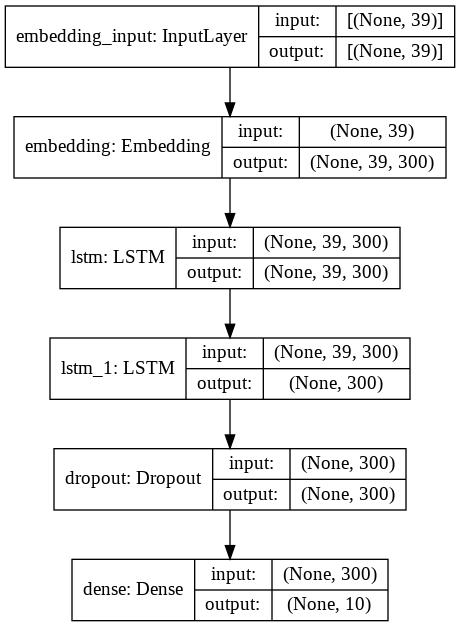

In [ ]:
#Graficar MODELO LSTM

plot_model(lstm_model, to_file='lstm_model.png',show_shapes=True)
display(Image(filename='lstm_model.png'))

### 2*.* Entrenar **MODELO LSTM**

Entrenamiento del modelo LSTM con 10 épocas y tamaño de lotes de 32 muestras

In [ ]:
print("Entrenar MODELO LSTM con Training y Validation set")

#Setear cantidad de épocas y batch_size
EPOCHS = 10
BATCH_SIZE = 32

history_lstm = lstm_model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid))
  
print(">> OK!")

Entrenar MODELO LSTM con Training y Validation set
Epoch 1/10
32/32 [==============================] - 31s 846ms/step - loss: 1.8991 - accuracy: 0.3377 - val_loss: 1.5813 - val_accuracy: 0.4505
Epoch 2/10
32/32 [==============================] - 19s 576ms/step - loss: 1.5091 - accuracy: 0.4612 - val_loss: 1.1712 - val_accuracy: 0.6126
Epoch 3/10
32/32 [==============================] - 24s 744ms/step - loss: 1.0499 - accuracy: 0.6477 - val_loss: 0.7115 - val_accuracy: 0.7658
Epoch 4/10
32/32 [==============================] - 17s 524ms/step - loss: 0.6297 - accuracy: 0.8036 - val_loss: 0.6405 - val_accuracy: 0.8198
Epoch 5/10
32/32 [==============================] - 14s 440ms/step - loss: 0.5580 - accuracy: 0.8244 - val_loss: 0.6389 - val_accuracy: 0.8018
Epoch 6/10
32/32 [==============================] - 24s 750ms/step - loss: 0.3770 - accuracy: 0.8781 - val_loss: 0.5395 - val_accuracy: 0.8559
Epoch 7/10
32/32 [==============================] - 23s 717ms/step - loss: 0.3851 - accurac

### 3*.* Evaluar **MODELO LSTM**

Predicción del Modelo LSTM sobre conjunto test. Se muestran los resultados obtenidos.

Evaluar MODELO LSTM
9/9 [==============================] - 6s 615ms/step - loss: 0.5216 - accuracy: 0.8520
>> Test accuracy con LSTM: 0.852
MATRIZ DE CONFUSIÓN - MODELO LSTM


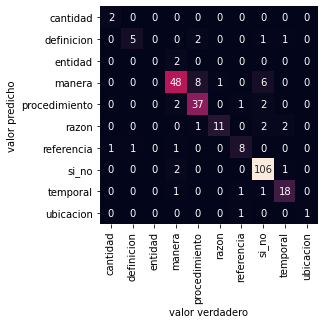

REPORTES DE CLASIFICACIÓN - MODELO LSTM
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.83      0.56      0.67         9
           2       0.00      0.00      0.00         2
           3       0.86      0.76      0.81        63
           4       0.77      0.88      0.82        42
           5       0.92      0.69      0.79        16
           6       0.73      0.73      0.73        11
           7       0.90      0.97      0.93       109
           8       0.82      0.86      0.84        21
           9       1.00      0.50      0.67         2

    accuracy                           0.85       277
   macro avg       0.75      0.69      0.70       277
weighted avg       0.85      0.85      0.85       277



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print("Evaluar MODELO LSTM")
#Evaluar y obtener Accuracy sobre test set:
score, acc = lstm_model.evaluate(test_data, test_labels,
                            batch_size=32)
acc_lstm = round(acc,3)
print('>> Test accuracy con LSTM:', acc_lstm)


#Obtener Matriz de Confusión y Reporte de Clasificación:
preds = lstm_model.predict(test_data)
preds_labels = np.argmax(preds, axis=1)
real_labels = np.argmax(test_labels, axis=1)
#print(np.argmax(preds, axis=1))
#print(np.argmax(test_labels, axis=1))
print('MATRIZ DE CONFUSIÓN - MODELO LSTM')
mat = confusion_matrix(preds_labels, real_labels)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, xticklabels=revertir_etiquetas(np.unique(real_labels)), yticklabels=revertir_etiquetas(np.unique(real_labels)),fmt='d' )
plt.xlabel('valor verdadero')
plt.ylabel('valor predicho');
plt.show()

print('REPORTES DE CLASIFICACIÓN - MODELO LSTM')
print(classification_report(real_labels,preds_labels))

#Registrar Resultados
loss_train = []
acc_val = []
for l in history_lstm.history['loss']:
  loss_train.append(round(l,2))

for av in history_lstm.history['val_accuracy']:
  acc_val.append(round(av,2))

DF_RESULTADOS = DF_RESULTADOS.append({'Dataset': DS_NAME, 'Modelo':"LSTM", 'lossTrain': loss_train, 'accValid':acc_val, 'accTestFinal' :acc_lstm } , ignore_index=True)



REGISTRO DE PREGUNTAS MAL CLASIFICADAS

In [ ]:
def revertirTexto(texto):
  #print(texto)
  new_txt = []
  for tk in texto:
    if tk!=0:
      for word, key in word_index.items():
        if key == tk:
          new_txt.append(word)
  #print(' '.join(new_txt))
  return (' '.join(new_txt))

preds_labels_txt = revertir_etiquetas(preds_labels)
real_labels_txt = revertir_etiquetas(real_labels)

for preg, pred, real in zip(test_data, preds_labels_txt, real_labels_txt):
  if pred != real:
    preg_txt = revertirTexto(preg)
    #print(preg, ' -CLASIFICADO COMO: ', pred, '  -DEBERIA SER: ', real,'\n') 
    global DF_MAL_CLF
    DF_MAL_CLF = DF_MAL_CLF.append({'DS': DS_NAME, 'MOD': "LSTM", 'Texto': preg_txt, 'Predicho': pred, 'Real':real}, ignore_index=True)

COMPORTAMIENTO DE ENTRENAMIENTO - **MODELO LSTM**

Se ilustra la curva de entrenamiento del modelo LSTM que refleja su comportamiento durante el proceso.

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

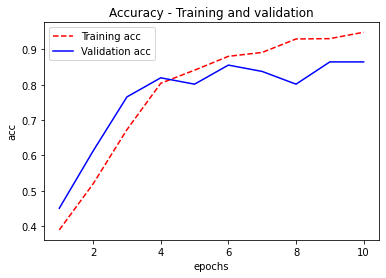

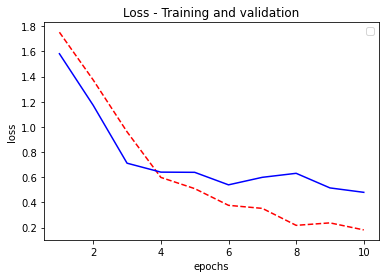

<Figure size 432x288 with 0 Axes>

In [ ]:
#Graficar comportamiento de entrenamiento
acc      = history_lstm.history[     'accuracy' ]
val_acc  = history_lstm.history[ 'val_accuracy' ]
loss     = history_lstm.history[    'loss' ]
val_loss = history_lstm.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Accuracy - Training and validation')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Loss - Training and validation'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

## **MODELO CNN**

###1*.* Construir **MODELO CNN**
Modelo Neuronal construído con las siguientes capas:

- Capa de Embedding
- Capa Conv1D (128 filtros y stride 2)
- Capa GlobalMaxPooling
- Capa Densa (256 neuronas)
- Capa de Salida (softmax)

In [ ]:
#Construir Modelo NN Convolucional
reset_random_seed()
print('Definición: Modelo CNN')

NUM_LABELS = len(np.unique(df_train['Etiqueta']))

cnn_model = Sequential()
cnn_model.add(embedding_layer)
## Accuracy cerca de 90%
cnn_model.add(Conv1D(128, 2, activation='relu')) #, padding='same'
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(256, activation='relu'))
###cnn_model.add(Dropout(0.5))  #No suele usarse dropout luego de una activación relu
cnn_model.add(Dense(NUM_LABELS, activation='softmax'))

cnn_model.compile(loss='categorical_crossentropy',
              optimizer='adam', #rmsprop
              metrics=['acc'])

print(">> OK!")

cnn_model.summary()

Definición: Modelo CNN
>> OK!
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 39, 300)           328500    
_________________________________________________________________
conv1d (Conv1D)              (None, 38, 128)           76928     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 441,022
Trainable params: 112,522
Non-trainable params: 328,500
_________________________________________________________________


Gráfica del modelo construído: CNN

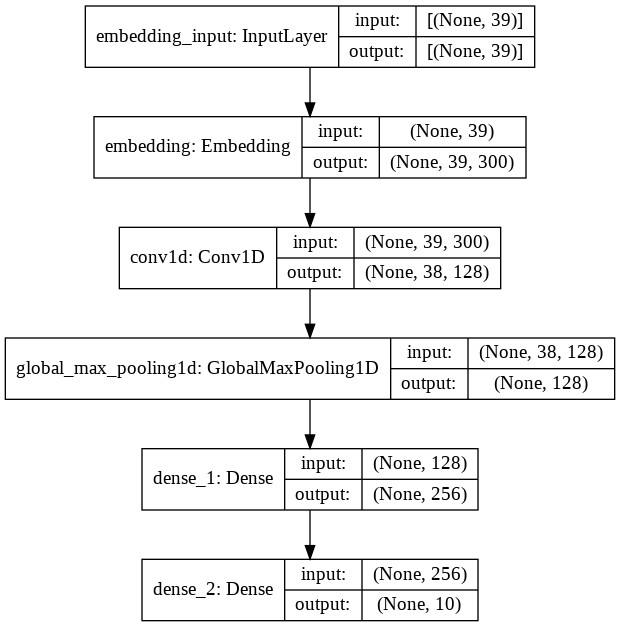

In [ ]:
#Graficar MODELO CONVOLUCIONAL

#from keras.utils import plot_model
#from IPython.display import Image, display
plot_model(cnn_model, to_file='cnn_model.png',show_shapes=True)
display(Image(filename='cnn_model.png'))

###2*.* Entrenar **MODELO CNN**

Entrenamiento del modelo CNN con 10 épocas y tamaño de lotes de 32 muestras

In [ ]:
print("Entrenar MODELO CONVOLUCIONAL con Training y Validation set")

#Setear cantidad de épocas y batch_size
EPOCHS = 10
BATCH_SIZE = 32

history_cnn = cnn_model.fit(X_train, y_train,
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(X_valid, y_valid))

print(">> OK!")

Entrenar MODELO CONVOLUCIONAL con Training y Validation set
Epoch 1/10
32/32 [==============================] - 1s 26ms/step - loss: 1.7657 - acc: 0.3882 - val_loss: 1.1457 - val_acc: 0.6306
Epoch 2/10
32/32 [==============================] - 1s 20ms/step - loss: 1.0822 - acc: 0.6396 - val_loss: 0.8256 - val_acc: 0.7658
Epoch 3/10
32/32 [==============================] - 1s 20ms/step - loss: 0.7023 - acc: 0.8093 - val_loss: 0.6042 - val_acc: 0.8288
Epoch 4/10
32/32 [==============================] - 1s 20ms/step - loss: 0.3815 - acc: 0.9002 - val_loss: 0.5382 - val_acc: 0.8468
Epoch 5/10
32/32 [==============================] - 1s 20ms/step - loss: 0.2848 - acc: 0.9246 - val_loss: 0.4830 - val_acc: 0.8739
Epoch 6/10
32/32 [==============================] - 1s 20ms/step - loss: 0.1609 - acc: 0.9722 - val_loss: 0.4212 - val_acc: 0.8649
Epoch 7/10
32/32 [==============================] - 1s 20ms/step - loss: 0.1389 - acc: 0.9704 - val_loss: 0.4517 - val_acc: 0.8649
Epoch 8/10
32/32 [=====

###3*.* Evaluar **MODELO CNN**
Predicción del Modelo CNN sobre conjunto test. Se muestran los resultados obtenidos.

Evaluar MODELO CONVOLUCIONAL con Test set
9/9 [==============================] - 0s 6ms/step - loss: 0.4583 - acc: 0.8736
>> Test accuracy con MODELO CONVOLUCIONAL: 0.874
MATRIZ DE CONFUSIÓN - MODELO CONVOLUCIONAL


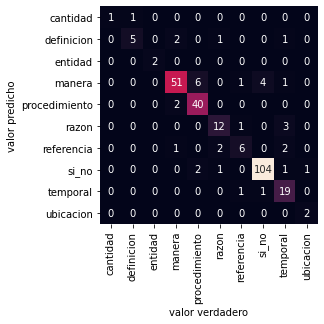

REPORTE DE CLASIFICACIÓN - MODELO CONVOLUCIONAL
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.56      0.83      0.67         6
           2       1.00      1.00      1.00         2
           3       0.81      0.91      0.86        56
           4       0.95      0.83      0.89        48
           5       0.75      0.75      0.75        16
           6       0.55      0.67      0.60         9
           7       0.95      0.95      0.95       109
           8       0.90      0.70      0.79        27
           9       1.00      0.67      0.80         3

    accuracy                           0.87       277
   macro avg       0.80      0.83      0.80       277
weighted avg       0.89      0.87      0.88       277



In [ ]:
print("Evaluar MODELO CONVOLUCIONAL con Test set")

#Evaluar y obtener Accuracy sobre test set:
score, acc = cnn_model.evaluate(test_data, test_labels,
                            batch_size=BATCH_SIZE)
acc_cnn = round(acc,3)
print('>> Test accuracy con MODELO CONVOLUCIONAL:', acc_cnn)


#Obtener Matriz de Confusión y Reporte de Clasificación:
preds = cnn_model.predict(test_data)
preds_labels = np.argmax(preds, axis=1)
real_labels = np.argmax(test_labels, axis=1)
#print(np.argmax(preds, axis=1))
#print(np.argmax(test_labels, axis=1))
print('MATRIZ DE CONFUSIÓN - MODELO CONVOLUCIONAL')
mat = confusion_matrix(preds_labels, real_labels)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, xticklabels=revertir_etiquetas(np.unique(real_labels)), yticklabels=revertir_etiquetas(np.unique(real_labels)),fmt='d' )
plt.xlabel('valor verdadero')
plt.ylabel('valor predicho');
plt.show()

print('REPORTE DE CLASIFICACIÓN - MODELO CONVOLUCIONAL')
print(classification_report(preds_labels, real_labels))

#Registrar Resultados
loss_train = []
acc_val = []
for l in history_cnn.history['loss']:
  loss_train.append(round(l,3))

for av in history_cnn.history['val_acc']:
  acc_val.append(round(av,3))

DF_RESULTADOS = DF_RESULTADOS.append({'Dataset': DS_NAME, 'Modelo':"CNN", 'lossTrain': loss_train, 'accValid':acc_val, 'accTestFinal' :acc_cnn } , ignore_index=True)


REGISTRO DE PREGUNTAS MAL CLASIFICADAS

In [ ]:
#Guardar Preguntas Mal Clasificadas
preds_labels_txt = revertir_etiquetas(preds_labels)  
real_labels_txt = revertir_etiquetas(real_labels)

for preg, pred, real in zip(test_data, preds_labels_txt, real_labels_txt):
  if pred != real:
    preg_txt = revertirTexto(preg)  #revertirTexto(..) -> Ya definido en la sección LSTM
    global DF_MAL_CLF
    DF_MAL_CLF = DF_MAL_CLF.append({'DS': DS_NAME, 'MOD': "CNN", 'Texto': preg_txt, 'Predicho': pred, 'Real':real}, ignore_index=True)

COMPORTAMIENTO DE ENTRENAMIENTO - **MODELO CNN**

Se ilustra la curva de entrenamiento del modelo CNN que refleja su comportamiento durante el proceso.

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

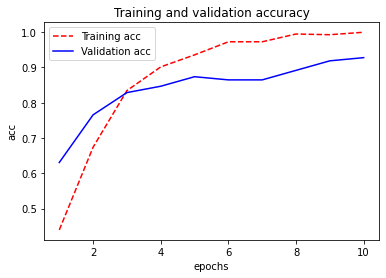

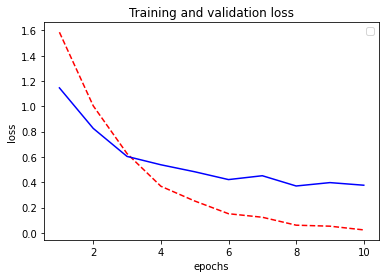

<Figure size 432x288 with 0 Axes>

In [ ]:
#Graficar comportamiento de entrenamiento
acc      = history_cnn.history[     'acc' ]
val_acc  = history_cnn.history[ 'val_acc' ]
loss     = history_cnn.history[    'loss' ]
val_loss = history_cnn.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('loss')
plt.xlabel('epochs')

plt.legend()
plt.figure()

## **MODELO HÍBRIDO**

###1*.* Construir **MODELO HÍBRIDO**
Modelo Neuronal construído con las siguientes capas:

- Capa de Embedding

Parte CNN:

- Capa Conv1D (128 filtros y stride 2)
- Capa GlobalMaxPooling
Capa Densa (256 neuronas)

Parte LSTM:
- Capa LSTM (retorno secuencia)
- Capa GlobalMaxPooling

Ultima Parte:
- Capa Concatenate (combina ambas Parte CNN y LSTM)
- Capa de Salida (softmax)



In [ ]:
#Construir Modelo NN HIBRIDO: LSTM + CNN

reset_random_seed()

print('Definición: Modelo Híbrido')
input_1 = Input(shape=(MAX_SEQUENCE_LENGTH,) , name='I1')
emb_1 = embedding_layer(input_1)
conv_1 = Conv1D(128,2,activation='relu', padding='same')(emb_1)
maxpool_1 = GlobalMaxPooling1D()(conv_1)
dense_1 = Dense(256,activation='relu')(maxpool_1)

input_2 = Input(shape=(MAX_SEQUENCE_LENGTH,), name='I2')
emb_2 = embedding_layer(input_2)
lstm_2a = LSTM(EMBEDDING_DIM, return_sequences=True)(emb_2)
lstm_2b = GlobalMaxPooling1D()(lstm_2a)

concat_layer = Concatenate()([dense_1, lstm_2b])


output_layer = Dense(10, activation='softmax', name='O1')(concat_layer)

final_model = Model(inputs=[input_1, input_2], outputs= [output_layer])

final_model.compile(loss='categorical_crossentropy', # entropía cruzada aplicada para muchas clases donde sólo una es verdadera
              optimizer='adam', #Optimizador "completo" 
              metrics=['accuracy'])
print('>> OK!')

final_model.summary()

Definición: Modelo Híbrido
>> OK!
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
I1 (InputLayer)                 [(None, 39)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 39, 300)      328500      I1[0][0]                         
                                                                 I2[0][0]                         
__________________________________________________________________________________________________
I2 (InputLayer)                 [(None, 39)]         0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 39, 128)      76928  

Gráfica del modelo construído: HÍBRIDO

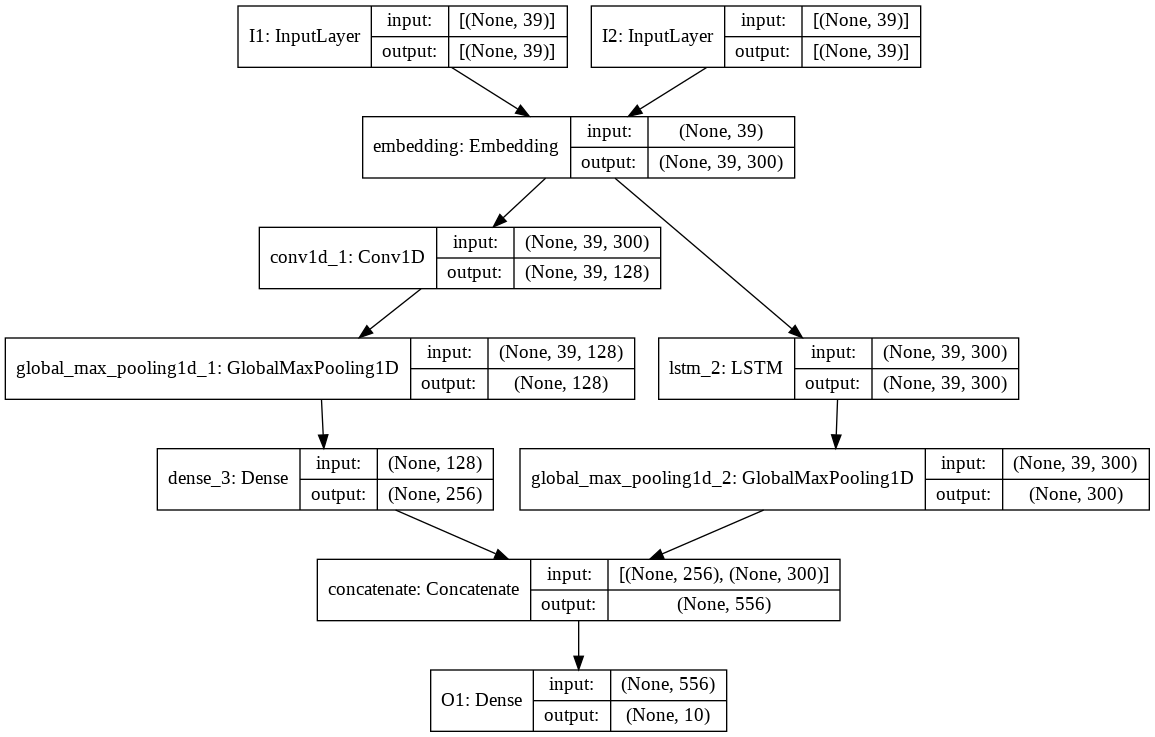

In [ ]:
#Graficar MODELO HIBRIDO

#from keras.utils import plot_model
#from IPython.display import Image, display
plot_model(final_model, to_file='hybrid_model.png',show_shapes=True)
display(Image(filename='hybrid_model.png'))

###2*.* Entrenar **MODELO HÍBRIDO**
Entrenamiento del modelo HÍBRIDO con 10 épocas y tamaño de lotes de 32 muestras

In [ ]:
print("Entrenar MODELO HÍBRIDO con Training y Validation set")

#Setear cantidad de épocas y batch_size
EPOCHS = 10
BATCH_SIZE = 32

history_hybrid = final_model.fit({'I1':X_train, 'I2':X_train},
                    {'O1':y_train},
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=([X_valid, X_valid], [y_valid]))

print(">> OK!")

Entrenar MODELO HÍBRIDO con Training y Validation set
Epoch 1/10
32/32 [==============================] - 15s 419ms/step - loss: 1.8318 - accuracy: 0.3687 - val_loss: 1.1825 - val_accuracy: 0.6036
Epoch 2/10
32/32 [==============================] - 16s 517ms/step - loss: 1.0859 - accuracy: 0.6553 - val_loss: 0.7550 - val_accuracy: 0.7297
Epoch 3/10
32/32 [==============================] - 16s 501ms/step - loss: 0.6744 - accuracy: 0.7852 - val_loss: 0.5171 - val_accuracy: 0.8288
Epoch 4/10
32/32 [==============================] - 13s 408ms/step - loss: 0.3781 - accuracy: 0.9106 - val_loss: 0.5031 - val_accuracy: 0.8378
Epoch 5/10
32/32 [==============================] - 12s 386ms/step - loss: 0.2699 - accuracy: 0.9282 - val_loss: 0.4508 - val_accuracy: 0.8649
Epoch 6/10
32/32 [==============================] - 17s 515ms/step - loss: 0.1537 - accuracy: 0.9660 - val_loss: 0.5368 - val_accuracy: 0.8378
Epoch 7/10
32/32 [==============================] - 15s 463ms/step - loss: 0.2630 - accu

###3*.* Evaluar **MODELO HÍBRIDO**
Predicción del Modelo HÍBRIDO sobre conjunto test. Se muestran los resultados obtenidos.

Evaluar MODELO HÍBRIDO con Test set
9/9 [==============================] - 1s 85ms/step - loss: 0.4802 - accuracy: 0.8809
>> Test accuracy con MODELO HIBRIDO: 0.881
MATRIZ DE CONFUSIÓN - MODELO HIBRIDO


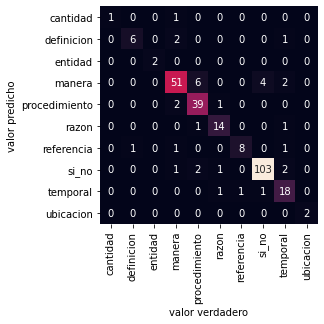

REPORTE DE CLASIFICACIÓN - MODELO HIBRIDO
              precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       0.67      0.86      0.75         7
           2       1.00      1.00      1.00         2
           3       0.81      0.88      0.84        58
           4       0.93      0.81      0.87        48
           5       0.88      0.82      0.85        17
           6       0.73      0.89      0.80         9
           7       0.94      0.95      0.95       108
           8       0.86      0.72      0.78        25
           9       1.00      1.00      1.00         2

    accuracy                           0.88       277
   macro avg       0.83      0.89      0.85       277
weighted avg       0.89      0.88      0.88       277



In [ ]:
print("Evaluar MODELO HÍBRIDO con Test set")

#Evaluar y obtener Accuracy sobre test set:
score, acc = final_model.evaluate([test_data, test_data], test_labels,
                            batch_size=BATCH_SIZE)
acc_hibrido = round(acc,3)
print('>> Test accuracy con MODELO HIBRIDO:', acc_hibrido)



#Obtener Matriz de Confusión y Reporte de Clasificación:
preds = final_model.predict([test_data, test_data])
preds_labels = np.argmax(preds, axis=1)
real_labels = np.argmax(test_labels, axis=1)
#print(np.argmax(preds, axis=1))
#print(np.argmax(test_labels, axis=1))
print('MATRIZ DE CONFUSIÓN - MODELO HIBRIDO')
mat = confusion_matrix(preds_labels, real_labels)
sns.heatmap(mat.T, square=True, annot=True, cbar=False, xticklabels=revertir_etiquetas(np.unique(real_labels)), yticklabels=revertir_etiquetas(np.unique(real_labels)),fmt='d' )
plt.xlabel('valor verdadero')
plt.ylabel('valor predicho');
plt.show()

print('REPORTE DE CLASIFICACIÓN - MODELO HIBRIDO')
print(classification_report(preds_labels, real_labels))


#Registrar Resultados
loss_train = []
acc_val = []
for l in history_hybrid.history['loss']:
  loss_train.append(round(l,2))

for av in history_hybrid.history['val_accuracy']:
  acc_val.append(round(av,2))

DF_RESULTADOS = DF_RESULTADOS.append({'Dataset': DS_NAME, 'Modelo':"HIBRIDO", 'lossTrain': loss_train, 'accValid':acc_val, 'accTestFinal' :acc_hibrido } , ignore_index=True)


REGISTRO DE PREGUNTAS MAL CLASIFICADAS

In [ ]:
#revertirTextos(..) y revertir_etiquetas(..) -> Ya definido en la sección LSTM

preds_labels_txt = revertir_etiquetas(preds_labels)
real_labels_txt = revertir_etiquetas(real_labels)

for preg, pred, real in zip(test_data, preds_labels_txt, real_labels_txt):
  if pred != real:
    preg_txt = revertirTexto(preg)  #revertirTexto(..) -> Ya definido en la sección LSTM
    #print(preg, ' -CLASIFICADO COMO: ', pred, '  -DEBERIA SER: ', real,'\n') 
    global DF_MAL_CLF
    DF_MAL_CLF = DF_MAL_CLF.append({'DS': DS_NAME, 'MOD': "HIBRIDO", 'Texto': preg, 'Predicho': pred, 'Real':real}, ignore_index=True)

COMPORTAMIENTO DE ENTRENAMIENTO - **MODELO HÍBRIDO**

Se ilustra la curva de entrenamiento del modelo HÍBRIDO que refleja su comportamiento durante el proceso.

No handles with labels found to put in legend.


<Figure size 432x288 with 0 Axes>

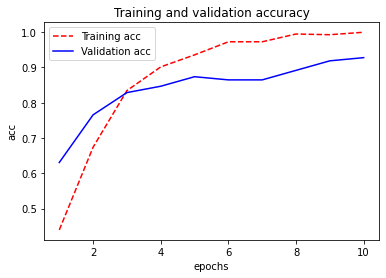

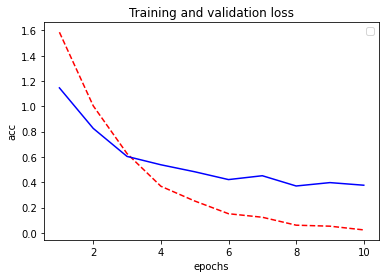

<Figure size 432x288 with 0 Axes>

In [ ]:
#Graficar comportamiento de entrenamiento
acc      = history_cnn.history[     'acc' ]
val_acc  = history_cnn.history[ 'val_acc' ]
loss     = history_cnn.history[    'loss' ]
val_loss = history_cnn.history['val_loss' ]

epochs   = range(1,len(acc)+1,1)

plt.plot ( epochs,     acc, 'r--', label='Training acc'  )
plt.plot ( epochs, val_acc,  'b', label='Validation acc')
plt.title ('Training and validation accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

plt.plot ( epochs,     loss, 'r--' )
plt.plot ( epochs, val_loss ,  'b' )
plt.title ('Training and validation loss'   )
plt.ylabel('acc')
plt.xlabel('epochs')

plt.legend()
plt.figure()

##GUARDAR RESULTADOS

In [ ]:
#Guardar Resultados en Archivo .csv

# Guardar Resultados
DF_RESULTADOS.to_csv(FILE_NAME_RES, index=None, mode="a", header=not os.path.isfile(FILE_NAME_RES))
print("Resultados guardados en:", FILE_NAME_RES)

# Guardar Preguntas Mal Clasificadas
DF_MAL_CLF.to_csv(FILE_NAME_CLF, index=None, mode="a", header=not os.path.isfile(FILE_NAME_CLF))
print("Resultados guardados en:", FILE_NAME_CLF)

Resultados guardados en: Resultados_CNN-LSTM-HIBRIDO.csv
Resultados guardados en: PregMalClasif_CNN-LSTM-HIBRIDO.csv


***>>FIN DE EXPERIMENTO***